In [ ]:
import os
import random
import cv2
import numpy as np
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from torchvision import transforms
from pathlib import Path
from torchtmpl.models.seg_models import *

data_dir = r"...\data"
DATA_ROOT = data_dir + r"\original_dataset\train" 

# path to .pt
logs_dir = r"...\logs"
MODEL_PATH = logs_dir + r"\DeepLabV3Plus_5\best_model.pt"


MODEL_ARCH = "DeepLabV3Plus"      
BACKBONE = "resnet34"   
IMG_SIZE = 224         
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Dictionnaire de mapping pour instancier facilement
MODEL_MAP = {
    "Unet": Unet,
    "DeepLabV3": DeepLabV3,
    "DeepLabV3Plus": DeepLabV3Plus,
    "UnetPlusPlus": UnetPlusPlus
}

In [94]:
def load_trained_model(path, arch, backbone, device):
    """Charge le modèle et les poids."""
    if arch not in MODEL_MAP:
        raise ValueError(f"Architecture {arch} inconnue.")
    
    # Configuration simulée comme dans ton training
    cfg = {"backbone": backbone, "pretrained": False} 
    input_size = (3, IMG_SIZE, IMG_SIZE)
    num_classes = 1 # Supposons binaire pour la segmentation
    
    # Instanciation
    model_class = MODEL_MAP[arch]
    model = model_class(cfg, input_size, num_classes)
    
    # Chargement des poids
    try:
        checkpoint = torch.load(path, map_location=device)
        # Si le checkpoint contient tout l'état (optimiseur, epoch...), on prend juste 'model_state_dict'
        # Sinon on suppose que c'est le state_dict direct
        if "model_state_dict" in checkpoint:
            model.load_state_dict(checkpoint["model_state_dict"])
        else:
            model.load_state_dict(checkpoint)
        print(f"Modèle {arch} chargé avec succès.")
    except Exception as e:
        print(f"Erreur lors du chargement des poids : {e}")
        print("Essai de chargement avec strict=False (parfois nécessaire si couches auxiliaires)...")
        try:
            model.load_state_dict(checkpoint, strict=False)
        except:
            pass

    model.to(device)
    model.eval()
    return model

def preprocess_image(img_path, resize_dim):
    """Lit, redimensionne et normalise l'image pour le modèle."""
    image = cv2.imread(str(img_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_image = image.copy() # On garde une copie propre pour l'affichage
    
    # Redimensionnement
    image = cv2.resize(image, (resize_dim, resize_dim))
    
    # Normalisation (Standard ImageNet)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    input_tensor = transform(image).unsqueeze(0) # Batch dimension [1, 3, H, W]
    return original_image, input_tensor

def apply_overlay(image, mask, color=(0, 255, 0), alpha=0.5):
    """Superpose le masque sur l'image."""
    # Redimensionner le masque à la taille de l'image originale pour l'affichage
    mask_resized = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    overlay = image.copy()
    # Créer une image de couleur unie
    colored_mask = np.zeros_like(image)
    colored_mask[:] = color
    
    # Appliquer la couleur seulement là où le masque est actif
    # Masque binaire
    mask_indices = mask_resized > 0.5
    
    overlay[mask_indices] = cv2.addWeighted(image[mask_indices], 1-alpha, colored_mask[mask_indices], alpha, 0)
    
    return overlay


'[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self-signed certificate in certificate chain (_ssl.c:1016)' thrown while requesting HEAD https://huggingface.co/smp-hub/resnet34.imagenet/resolve/7a57b34f723329ff020b3f8bc41771163c519d0c/config.json
Retrying in 1s [Retry 1/5].


Modèle DeepLabV3Plus chargé avec succès.
Classes sélectionnées : ['071_Obelia', '037_feces', '011_Euchaeta', '070_zoea_brachyura', '078_Microstella']


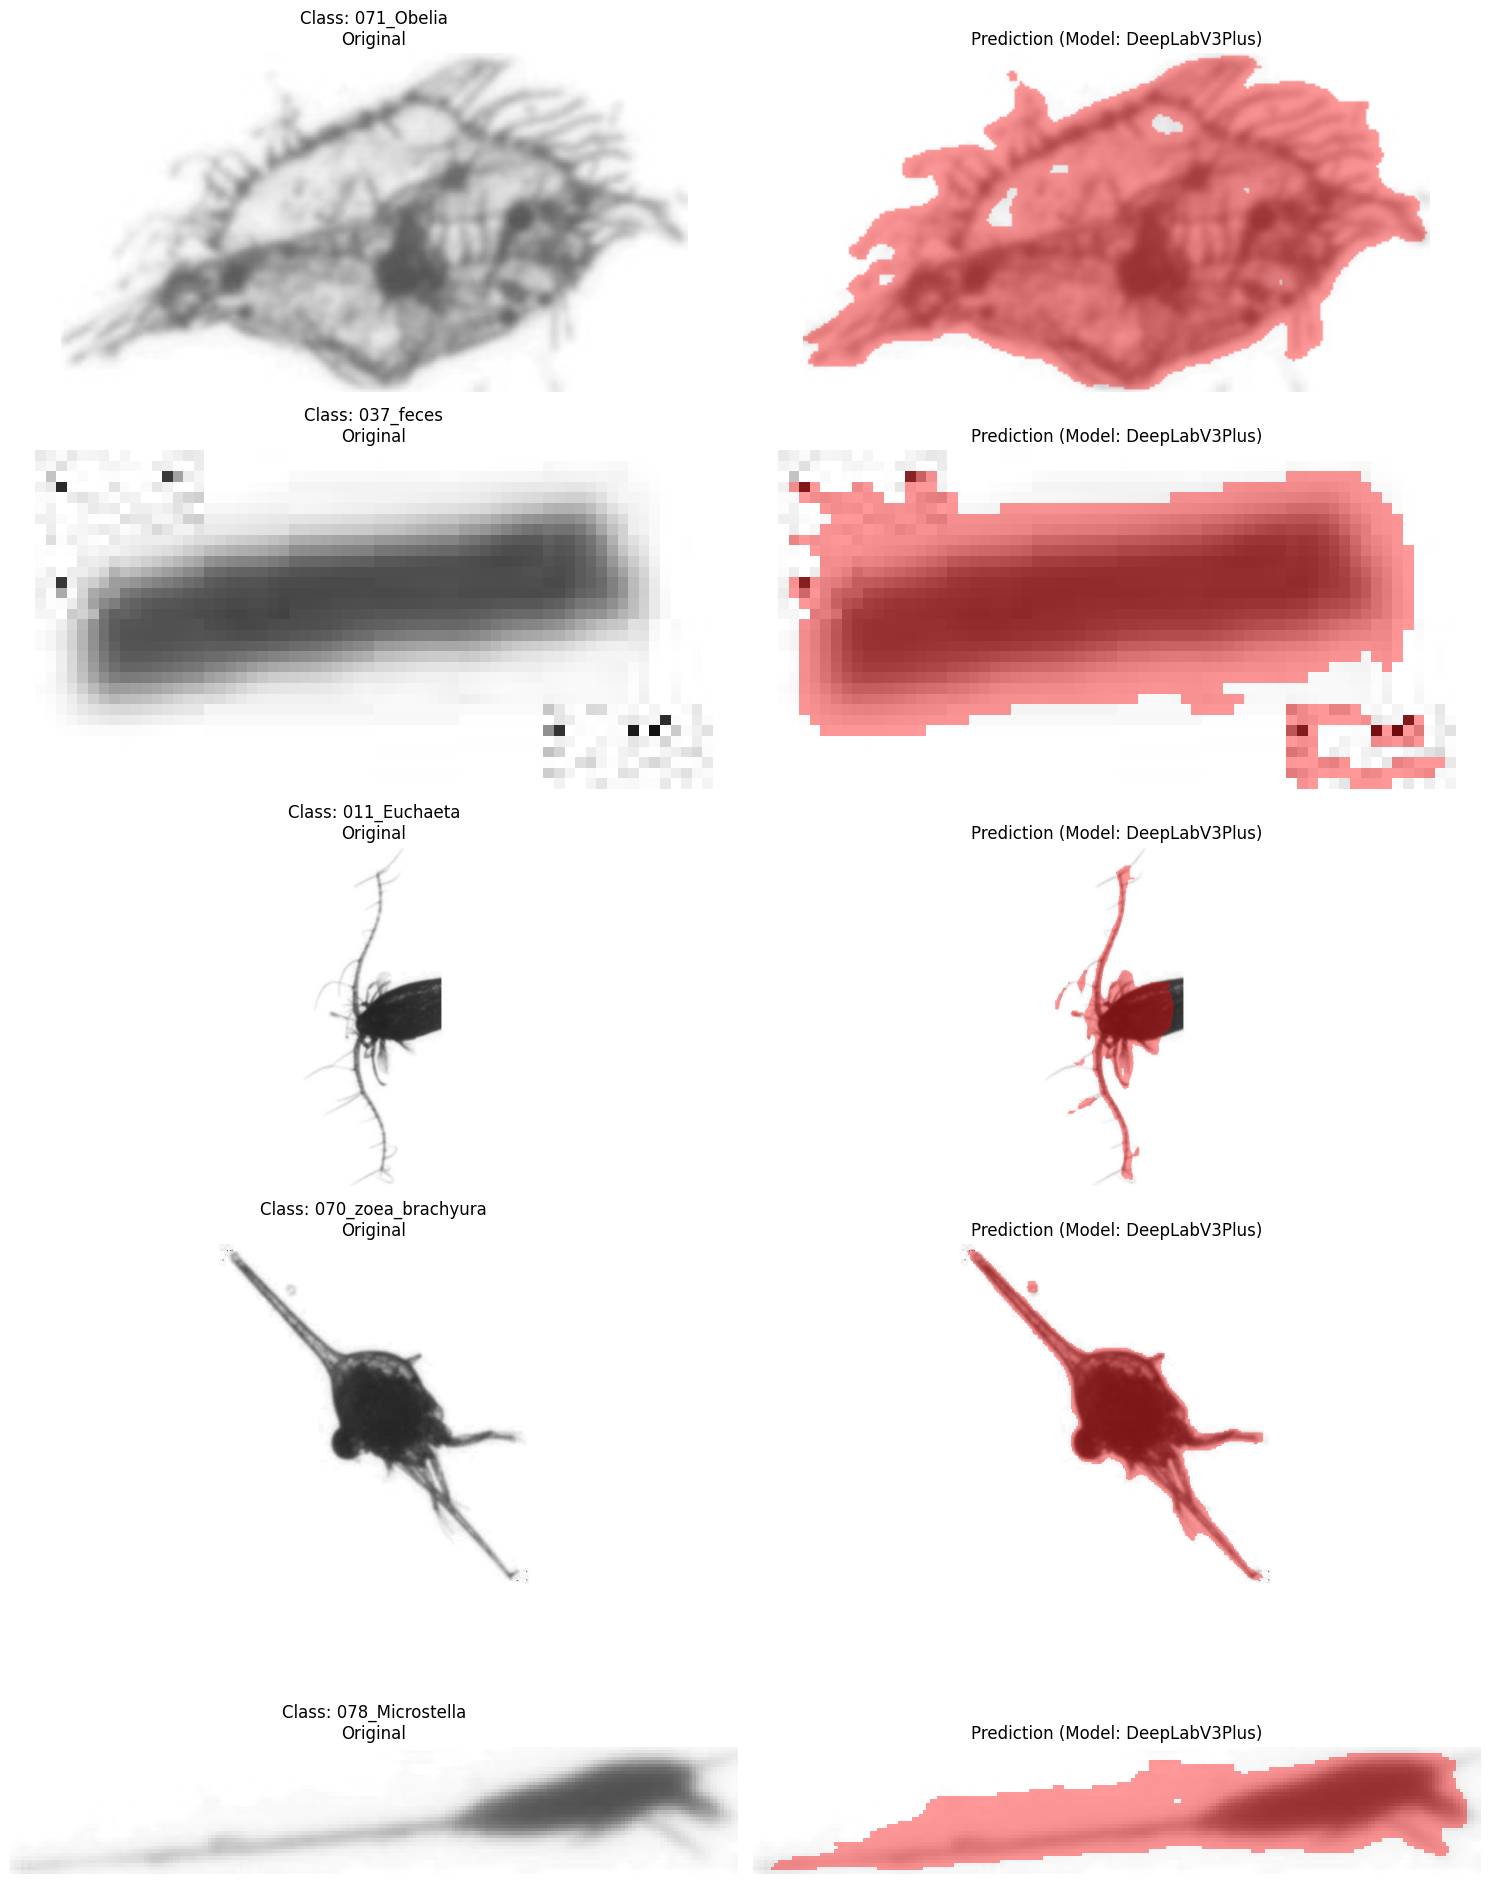

In [95]:
# 1. Charger le modèle
model = load_trained_model(MODEL_PATH, MODEL_ARCH, BACKBONE, DEVICE)

# 2. Trouver les dossiers de classes
root_path = Path(DATA_ROOT)
classes = [d for d in root_path.iterdir() if d.is_dir()]

if len(classes) < 5:
    print(f"Attention : Seulement {len(classes)} classes trouvées.")
    selected_classes = classes
else:
    selected_classes = random.sample(classes, 5)

print(f"Classes sélectionnées : {[c.name for c in selected_classes]}")

# 3. Boucle de prédiction et affichage
plt.figure(figsize=(15, 20))

for i, class_dir in enumerate(selected_classes):
    # Trouver une image au hasard (jpg, png, jpeg...)
    images = list(class_dir.glob("*.jpg")) + list(class_dir.glob("*.png"))
    if not images:
        continue
        
    img_path = random.choice(images)
    
    # Préparer l'image
    original_img, input_tensor = preprocess_image(img_path, IMG_SIZE)
    input_tensor = input_tensor.to(DEVICE)
    
    # Inférence
    with torch.no_grad():
        output = model(input_tensor)
        # Sigmoid pour transformer les logits en probabilités (0 à 1)
        prob_mask = torch.sigmoid(output).squeeze().cpu().numpy()
        
        # Binarisation (Seuil à 0.5)
        pred_mask = (prob_mask > 0.5).astype(np.uint8)

    # Création de l'overlay
    overlay_img = apply_overlay(original_img, pred_mask, color=(255, 0, 0), alpha=0.4) # Rouge transparent

    # Affichage Matplotlib
    # Colonne gauche : Image originale
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(original_img)
    plt.title(f"Class: {class_dir.name}\nOriginal")
    plt.axis("off")
    
    # Colonne droite : Segmentation
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(overlay_img)
    plt.title(f"Prediction (Model: {MODEL_ARCH})")
    plt.axis("off")

plt.tight_layout()
plt.show()


Validation sur 5 images...


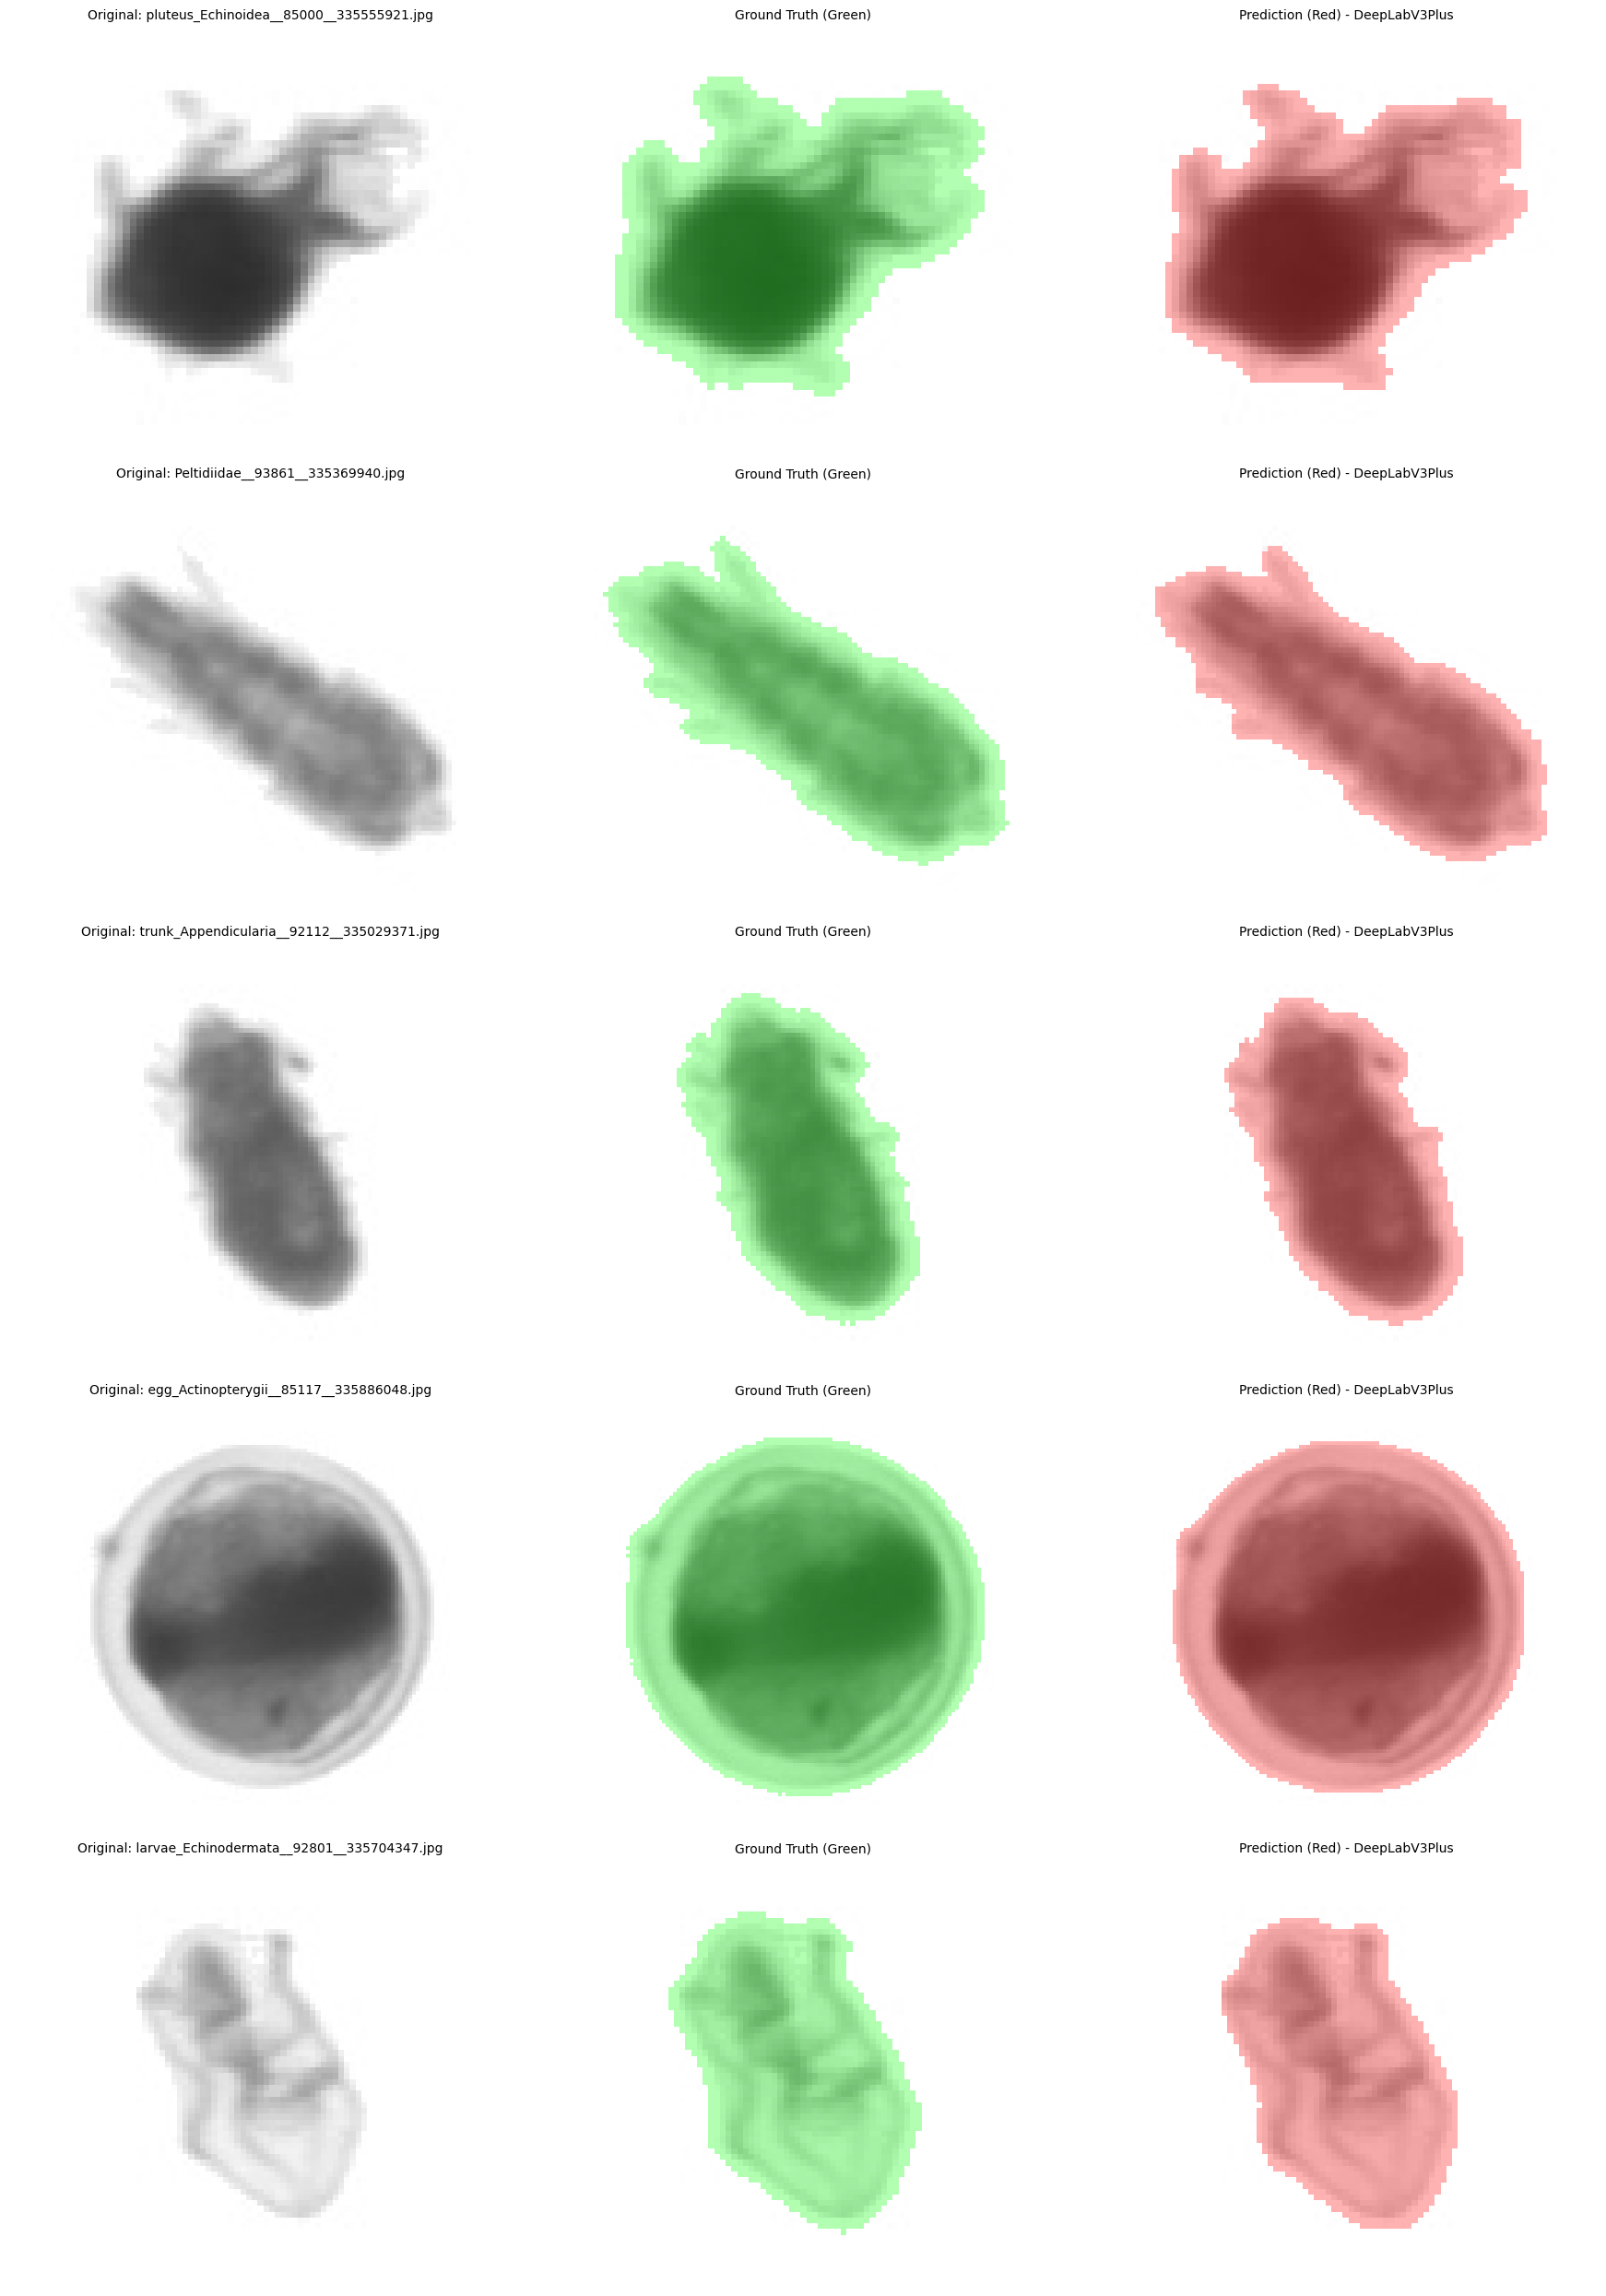

In [ ]:
# --- CONFIGURATION DATASET DE VALIDATION ---
# Chemin racine contenant les dossiers "imgs" et "masks"
VAL_DS_ROOT = data_dir + r"\segmentation_dataset_cropped"
NUM_SAMPLES = 5  # Nombre d'images à tester

# Chemins
val_img_dir = Path(VAL_DS_ROOT) / "imgs"
val_mask_dir = Path(VAL_DS_ROOT) / "masks"

# Récupération des images
all_val_images = list(val_img_dir.glob("*.jpg")) + list(val_img_dir.glob("*.png"))

if len(all_val_images) < NUM_SAMPLES:
    selected_val = all_val_images
else:
    selected_val = random.sample(all_val_images, NUM_SAMPLES)

print(f"Validation sur {len(selected_val)} images...")

plt.figure(figsize=(18, 5 * len(selected_val)))

for i, img_path in enumerate(selected_val):
    # 1. Trouver le masque correspondant
    # On essaye de remplacer l'extension (ex .jpg -> .png) ou de garder le même nom
    possible_extensions = [".png", ".jpg", ".bmp", ".tif"]
    mask_path = None
    
    for ext in possible_extensions:
        candidate = val_mask_dir / img_path.with_suffix(ext).name
        if candidate.exists():
            mask_path = candidate
            break
            
    if mask_path is None:
        print(f"Masque introuvable pour {img_path.name}, on saute.")
        continue

    # 2. Chargement Image & Masque GT
    # Image pour le modèle
    original_img, input_tensor = preprocess_image(img_path, IMG_SIZE)
    input_tensor = input_tensor.to(DEVICE)
    
    # Masque Vérité Terrain (Ground Truth)
    gt_mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if gt_mask is None: continue
    
    # On s'assure que le GT est redimensionné comme l'image originale (au cas où)
    gt_mask = cv2.resize(gt_mask, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 3. Prédiction
    with torch.no_grad():
        output = model(input_tensor)
        prob_mask = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_mask_small = (prob_mask > 0.5).astype(np.uint8)

    # 4. Post-traitement pour affichage
    # On remet la prédiction à la taille d'origine pour la superposer proprement
    pred_mask_full = cv2.resize(pred_mask_small, (original_img.shape[1], original_img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # Création des overlays
    # Overlay GT (Vert)
    overlay_gt = apply_overlay(original_img, gt_mask, color=(0, 255, 0), alpha=0.3)
    # Overlay Pred (Rouge)
    overlay_pred = apply_overlay(original_img, pred_mask_full, color=(255, 0, 0), alpha=0.3)

    # 5. Affichage (3 colonnes)
    # Col 1: Image brute
    plt.subplot(len(selected_val), 3, 3*i + 1)
    plt.imshow(original_img)
    plt.title(f"Original: {img_path.name}", fontsize=10)
    plt.axis("off")

    # Col 2: Vérité Terrain (Masque)
    plt.subplot(len(selected_val), 3, 3*i + 2)
    plt.imshow(overlay_gt)
    plt.title("Ground Truth (Green)", fontsize=10)
    plt.axis("off")

    # Col 3: Prédiction
    plt.subplot(len(selected_val), 3, 3*i + 3)
    plt.imshow(overlay_pred)
    plt.title(f"Prediction (Red) - {MODEL_ARCH}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()
